In [262]:
%reset
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Read all documents

In [263]:
# Get a list of all document names
namelist = glob.glob("C:/Users/**********.xlsx")

In [264]:
# Format document
def convert_format(RFP_Doc):
    PriceList = RFP_Doc[12:]
    PriceList.columns = PriceList.iloc[0]
    PriceList = PriceList[1:]
    PriceList = PriceList.drop(PriceList.columns[[0]], axis=1)
    PriceList['Supplier Name'] = RFP_Doc['INC.'][2]
    PriceList['Purchase Site'] = RFP_Doc['INC.'][3]
    PriceList['Blade'] = RFP_Doc['INC.'][4]
    PriceList['Material Category'] = RFP_Doc['INC.'][5]
    PriceList['Currency'] = RFP_Doc['INC.'][6]
    PriceList['Payment Term'] = RFP_Doc['INC.'][7]
    PriceList['Incom Term'] = RFP_Doc['INC.'][8]
    PriceList['VMI'] = RFP_Doc['INC.'][9]
    PriceList['Date'] = RFP_Doc['INC.'][10]
    return PriceList

In [265]:
# Consolidate documents
QuoteList = []
AllPrices = []
for name in namelist:
    var_name = name.split("\\")[1].split(".x")[0]
    QuoteList.append(var_name)
    vars()[var_name] = convert_format(pd.read_excel(name))
    AllPrices.append(convert_format(pd.read_excel(name)))
result = pd.concat(AllPrices)[['Purchase Site', 'Blade','Supplier Name', 'VMI', 'Incom Term', 'Payment Term','Material Category', 'TPI Part No.', 'TPI Item Description', 'OEM Specification', 'UOM', 'Unit Cost', 'Loggistics Cost', 'Packaging Cost', 'Landed Cost', 'MOQ', 'Currency', 'Date', 'Container', 'HS Code', 'Pakaging Type', 'Pallet']]


## Model 1: Export All Data 

##### This Model will export all supplier Prices in a list

In [266]:
# export result to excel
writer = pd.ExcelWriter('C:/Users/************.xlsx')
result.to_excel(writer,'Sheet1')
writer.save()

## Model 2: Export Single Supplier Quotations

##### This Model will export single suppliers as requested. The data for one supplier will store in one excel sheet.

In [267]:
add = 'y'
writer = pd.ExcelWriter('C:/Users/************.xlsx')
while add == 'y':    
    supplier = input('Please input the supplier you want to check: \n')
    result_sup = result.loc[result['Supplier Name'] == supplier]
    result_sup.to_excel(writer, supplier)
    add = input('Please input y to add more suppliers or input n to export results. \n')

writer.save()

Please input the supplier you want to check: 
Hexion
Please input y to add more suppliers or input n to export results. 
y
Please input the supplier you want to check: 
Olin
Please input y to add more suppliers or input n to export results. 
n


## Model 3: Export Quotation by Site and Category

##### This Model will export all quotations by site by category

In [268]:
table = pd.pivot_table(result, values='Landed Cost', index=['Part No.', 'Item Description'], columns=['Purchase Site', 'Material Category', 'Supplier Name', 'Incom Term', 'VMI', 'Payment Term'], aggfunc=np.sum)
writer = pd.ExcelWriter('C:/Users/************.xlsx')
table.to_excel(writer,'AllQuotation')
writer.save()

## Model 4: Export Quotation for One Site One Category

##### This Model will single site and category export quotations as requested. One result will be store in two sheets include a list of prices and an analysis sheet.

In [270]:
add = 'y'
writer = pd.ExcelWriter('C:/Users/************.xlsx')
while add == 'y':    
    site = input('Please input the site you want to check: \n')
    category = input('Please input the category you want to check: \n')
    result_sup = result.loc[result['Purchase Site'] == site]
    result_sup = result_sup.loc[result_sup['Material Category'] == category]
    result_sup.to_excel(writer, site + ' ' + category)
    table_SiteCategory = pd.pivot_table(result_sup, values='Landed Cost', index=['Part No.', 'Item Description'], columns=['Supplier Name', 'Incom Term', 'VMI', 'Payment Term'], aggfunc=np.sum)
    table_SiteCategory.to_excel(writer, site + ' ' + category + ' Analysis')
    add = input('Please input y to add more suppliers or input n to export results. \n')
writer.save()

Please input the site you want to check: 
Mexico
Please input the category you want to check: 
Adhesive
Please input y to add more suppliers or input n to export results. 
y
Please input the site you want to check: 
Turkey
Please input the category you want to check: 
Resin
Please input y to add more suppliers or input n to export results. 
n


## Model 5: Compared with Baseline Price - Cost Out
#### Only have data for Turkey Resin now...

##### This is a model to show that we can do calculation and data visualization.

In [276]:
result_CostOut = result.loc[result['Purchase Site'] == 'Turkey']
result_CostOut = result_CostOut.loc[result_CostOut['Material Category'] == 'Resin'] 
result_CostOut['Extended Cost'] = result_CostOut['MOQ'] * result_CostOut['Landed Cost']

In [277]:
table_CostOut = pd.pivot_table(result_CostOut, values='Extended Cost', columns=['Supplier Name'], aggfunc=np.sum)
table_CostOut.loc['Cost Out'] = [table_CostOut['Baseline'][0] - table_CostOut['Baseline'][0], table_CostOut['Hexion'][0] - table_CostOut['Baseline'][0], table_CostOut['Huntsman'][0] - table_CostOut['Baseline'][0], table_CostOut['Olin'][0] - table_CostOut['Baseline'][0], table_CostOut['Swancor'][0] - table_CostOut['Baseline'][0]]
table_CostOut.loc['Cost Out %'] = ["{0:.1%}".format(table_CostOut['Baseline'][0] / table_CostOut['Baseline'][0] - 1), "{0:.1%}".format(table_CostOut['Hexion'][0] / table_CostOut['Baseline'][0] - 1), "{0:.1%}".format(table_CostOut['Huntsman'][0] / table_CostOut['Baseline'][0] - 1), "{0:.1%}".format(table_CostOut['Olin'][0] / table_CostOut['Baseline'][0] - 1), "{0:.1%}".format(table_CostOut['Swancor'][0] / table_CostOut['Baseline'][0] - 1)]


In [283]:
writer = pd.ExcelWriter('C:/Users/************.xlsx')
table_CostOut.to_excel(writer, 'CostOut')
writer.save()

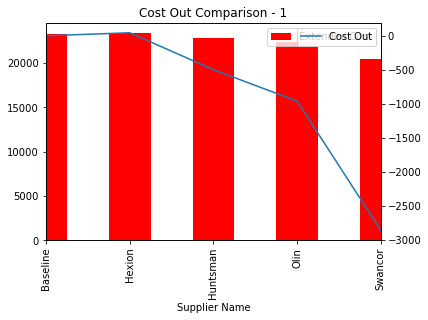

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
table_CostOut.loc['Extended Cost'].plot(kind='bar', color='red', ax=ax, legend = True, mark_right = True)
table_CostOut.loc['Cost Out'].plot(kind='line', ax=ax2, legend = True)
plt.title('Cost Out Comparison - 1')
plt.show()
plt.savefig('Cost Out 1.png')

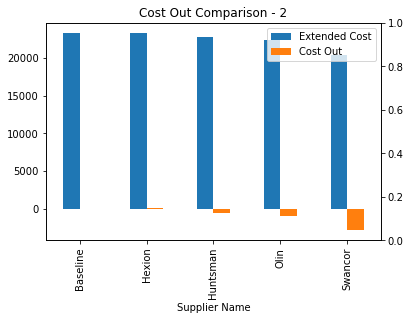

In [282]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
table_CostOut.loc[['Extended Cost', 'Cost Out']].T.plot(kind='bar', ax=ax, legend = True, mark_right = False)
plt.title('Cost Out Comparison - 2')
plt.show()
plt.savefig('Cost Out 2.png')